In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import networkx as nx

from scipy.spatial import distance

In [2]:
%%time
rna_cna = pd.read_csv("../data/interim/FRP_copykat_CNA_results.txt", sep = "\t", index_col = 2)
rna_anno = pd.read_csv("../data/interim/FRP_copykat_CNA_raw_results_gene_by_cell.txt", sep = "\t",usecols = [0, 1, 2,3,4,5], index_col = 0)

CPU times: user 1min 44s, sys: 3.18 s, total: 1min 47s
Wall time: 1min 47s


In [3]:
chroms = rna_cna.chrom
rna_cna = rna_cna.drop(columns = ["chrom","chrompos"])
rna_anno["abspos"] = rna_anno.index
rna_cna = rna_cna.T
rna_cna.index = [x.replace(".","-") for x in rna_cna.index]

In [4]:
rna_var = rna_cna.std(axis = 1)
rna_cell_anno = pd.read_csv("../data/interim/FRP_copykat_prediction.txt", sep = "\t", index_col = 0)
rna_var.name = "variance"

In [5]:
rna_cell_anno = rna_cell_anno.merge(rna_var, right_index=True, left_index=True)
rna_cell_anno = rna_cell_anno.sort_values(by = "variance", ascending = False)
rna_cell_anno["id"] = np.arange(0, len(rna_cell_anno))

In [6]:
tumor_cells_rna = rna_cell_anno[(rna_cell_anno["copykat.pred"]!="not.defined") & (rna_cell_anno.variance >= 0.04)].index

In [7]:
rna_cell_anno[rna_cell_anno["copykat.pred"]=="not.defined"].to_csv("../data/interim/noisy_cells.csv")

In [8]:
rna_cna_f = rna_cna.copy().loc[tumor_cells_rna]

In [9]:
adata_sc = sc.AnnData(rna_cna_f)


/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
num_comp = 50
sc.tl.pca(adata_sc, svd_solver='arpack', n_comps = num_comp)

In [11]:
sc.pp.neighbors(adata_sc, n_pcs=num_comp)


/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packag

In [12]:
clones = pd.read_csv("../data/interim/clones_sc.csv",index_col = 0)

In [13]:
adata_sc.obs.drop(columns = ["leiden"], inplace = True)

KeyError: "['leiden'] not found in axis"

In [14]:
adata_sc.obs = adata_sc.obs.join(clones)

In [15]:
Counter(adata_sc.obs.leiden)

Counter({8: 462,
         5: 832,
         3: 926,
         2: 1694,
         6: 574,
         7: 560,
         1: 2073,
         0: 2753,
         4: 847})

In [16]:
adata_sc.obs.leiden = adata_sc.obs.leiden.astype("category")

In [17]:
del adata_sc.uns["leiden_sizes"]
del adata_sc.uns["leiden_colors"]

KeyError: 'leiden_sizes'

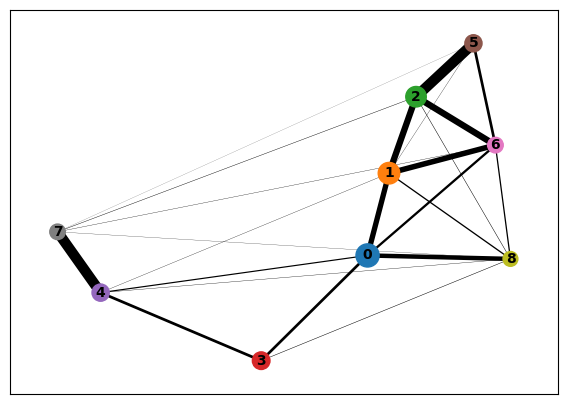

In [18]:
sc.tl.paga(adata_sc)
sc.pl.paga(adata_sc, plot=True) 

In [21]:
sc.tl.umap(adata_sc, init_pos='paga')


/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


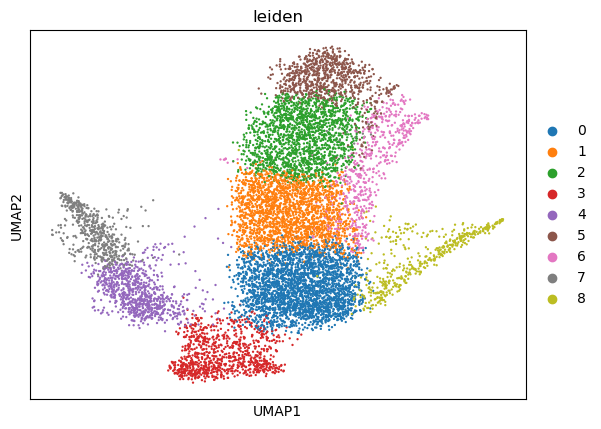

In [22]:
sc.pl.umap(adata_sc, color=["leiden"])

In [28]:
sc.tl.leiden(adata_sc, resolution = 4, key_added = "leiden_2")


/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


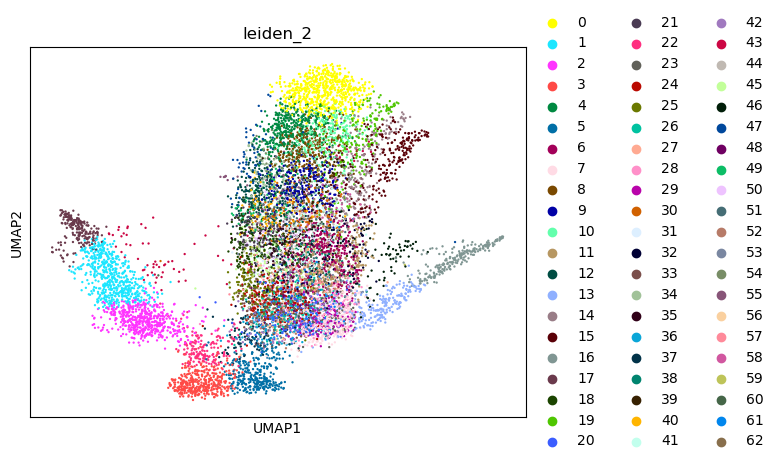

In [29]:
sc.pl.umap(adata_sc, color=["leiden_2"])

In [24]:
adata_sc.uns["leiden_colors"]

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22']

In [32]:
adata_sc.obs.leiden.replace({3:'8'}, inplace = True)
adata_sc.obs.leiden.replace({8:3}, inplace = True)
adata_sc.obs.leiden.replace({'8':8}, inplace = True)

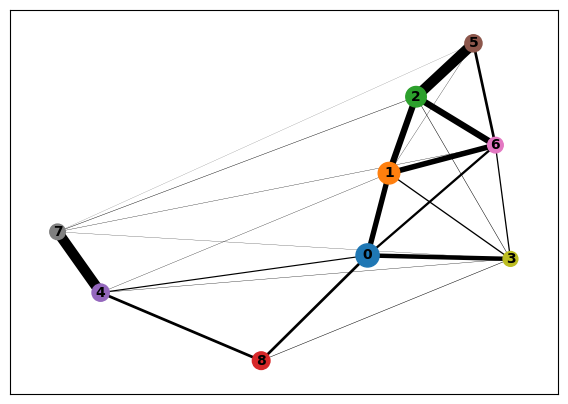

In [33]:
sc.tl.paga(adata_sc)
sc.pl.paga(adata_sc, plot=True) 

In [34]:
dist_clones = adata_sc.uns['paga']['connectivities'].todense()

<Axes: >

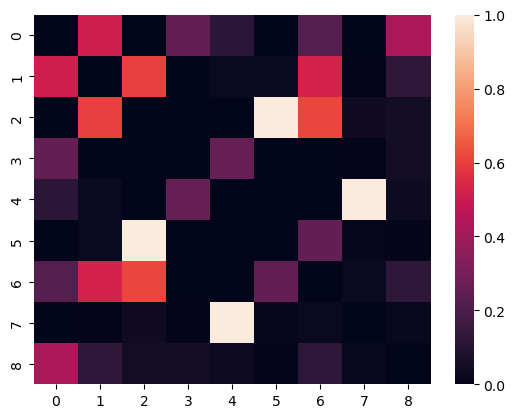

In [35]:
sns.heatmap(dist_clones)

In [36]:
def apply_penalty(matrix, threshold, penalty):
    # Create a copy of the matrix
    result = np.copy(matrix)
    
    # Apply penalty to values larger than the threshold
    result[result > threshold] -= penalty
    
    # Fill the main diagonal with 1
    np.fill_diagonal(result, 1)
    
    return result

<Axes: >

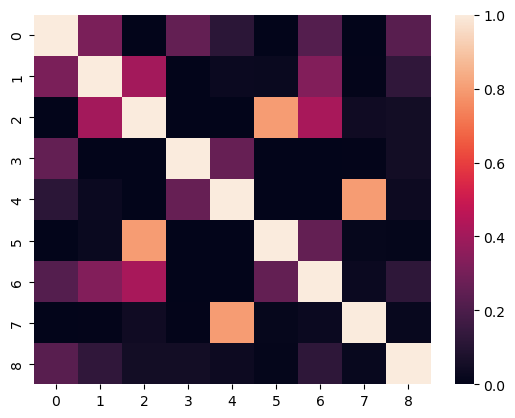

In [38]:
dist = apply_penalty(dist_clones,0.3,0.2)
sns.heatmap(dist)

In [39]:
np.save("../data/interim/clone_dist.npy",dist)

In [40]:
cl = adata_sc.obs["leiden"].astype(str)
cl = cl.replace({"8":"diploid"})
cl.to_csv("../data/interim/clones.csv")